In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import rasterio
import tqdm
import pandas as pd
import rasterio
import random
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

In [3]:
path_data = "/home/gt/DATA/geolifeclef-2025"
train_metadata = pd.read_csv(os.path.join(path_data, "GLC25_PA_metadata_train.csv"))
train_metadata = train_metadata.dropna(subset="speciesId").reset_index(drop=True)
train_metadata['speciesId'] = train_metadata['speciesId'].astype(int)
train_label_dict = train_metadata.groupby('surveyId')['speciesId'].apply(list).to_dict()
train_metadata = train_metadata.drop_duplicates(subset="surveyId").reset_index(drop=True).drop('speciesId', axis=1)
train_metadata['areaInM2'].fillna((train_metadata['areaInM2'].mean()), inplace=True)
train_metadata["conFra"] = train_metadata["country"] == "France"
train_metadata["conDen"] = train_metadata["country"] == "Denmark"
train_metadata["conNet"] = train_metadata["country"] == "Netherlands"
train_metadata["conIta"] = train_metadata["country"] == "Italy"
train_metadata["conOther"] = ~train_metadata["country"].isin(["France","Denmark","Netherlands","Italy"])
train_elevation = pd.read_csv(os.path.join(path_data, "EnvironmentalValues", "Elevation", "GLC25-PA-train-elevation.csv"))
train_elevation['Elevation'].fillna((train_elevation['Elevation'].mean()), inplace=True)
train_soil = pd.read_csv(os.path.join(path_data, "EnvironmentalValues", "SoilGrids", "GLC25-PA-train-soilgrids.csv"))
meta_columns = ["areaInM2", "Elevation", "conFra", "conDen", "conNet", "conIta", "conOther"]

In [4]:
path_data = "/home/gt/DATA/geolifeclef-2025"
train_metadata = pd.read_csv(os.path.join(path_data, "GLC25_PA_metadata_train.csv"))
train_metadata['speciesId'] = train_metadata['speciesId'].astype(int)
train_metadata

,lon,lat,year,geoUncertaintyInM,areaInM2,region,country,speciesId,surveyId
0,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,6874,212
1,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,476,212
2,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,11157,212
3,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,8784,212
4,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,4530,212
...,...,...,...,...,...,...,...,...,...
1483632,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,53,3919655
1483633,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,5071,3919655
1483634,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,1889,3919655
1483635,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,10600,3919655


In [5]:
display((train_metadata.areaInM2 == -np.inf).sum())
display(train_metadata.areaInM2.isna().sum())

51592

183272

In [6]:
tmp = train_metadata.groupby("surveyId").agg({"surveyId":"first", "lat":"first", "lon":"first", "areaInM2":lambda x: list(x.unique()), "geoUncertaintyInM":lambda x: list(x.unique()), "region":"first", "country":"first", "speciesId":list})
tmp.rename(columns={"areaInM2": "area", "geoUncertaintyInM": "uncert"}, inplace=True)
tmp.insert(np.where(tmp.columns=="area")[0][0]+1, "areaList", tmp["area"])
tmp["area"] = tmp["areaList"].apply(np.mean)
print((tmp.area == -np.inf).sum(), tmp.area.isna().sum())
tmp["area"] = tmp["areaList"].apply(lambda x: 1.0 if np.isinf(x).all() else np.mean(x, where=~np.isinf(x)))
print((tmp.area == -np.inf).sum(), tmp.area.isna().sum())
tmp['area'].fillna(tmp['area'].mean(), inplace=True)
print((tmp.area == -np.inf).sum(), tmp.area.isna().sum())
tmp.insert(np.where(tmp.columns=="uncert")[0][0]+1, "uncertList", tmp["uncert"])
tmp["uncert"] = tmp["uncert"].apply(np.mean)
tmp["speciesId"] = tmp["speciesId"].apply(np.sort)
tmp["spLenOrig"] = tmp["speciesId"].apply(len)
tmp["spLen"] = tmp["speciesId"].apply(np.unique).apply(len)
tmp.sort_values(["spLen","area"], ascending=[True,False], inplace=True)

3113 9419
0 9419
0 0


In [7]:
train_worldcover = pd.read_csv(os.path.join(path_data, "worldcover", "s2_pa_train_survey_points_with_worldcover.csv"))
train_worldcover['surveyId'] = train_worldcover['surveyId'].astype(int)
train_worldcover.set_index("surveyId", inplace=True)
comb = pd.concat([tmp.sort_index(), train_worldcover.sort_values("surveyId")["class"]], axis=1)
comb

,surveyId,lat,lon,area,areaList,uncert,uncertList,region,country,speciesId,spLenOrig,spLen,class
surveyId,,,,,,,,,,,,,
212,212,43.134956,3.099038,100.000000,[100.0],5.0,[5.0],MEDITERRANEAN,France,"[51, 476, 982, 1304, 2159, 2421, 2932, 3935, 4...",16,16,10
222,222,56.912140,9.884560,79.000000,[79.0],10.0,[10.0],CONTINENTAL,Denmark,"[254, 433, 540, 4499, 9816]",5,5,30
243,243,55.637050,8.256020,79.000000,[79.0],10.0,[10.0],ATLANTIC,Denmark,"[129, 254, 1387, 3227, 4077, 4638, 5384, 5386,...",14,14,30
324,324,43.505630,-0.402590,118.648592,[nan],1.0,[1.0],ATLANTIC,France,"[146, 694, 2386, 6788, 9028, 9388]",6,6,10
333,333,45.806430,-0.517360,118.648592,[nan],1.0,[1.0],ATLANTIC,France,"[981, 1888, 2474, 2852, 3935, 5071, 5189, 8151...",9,9,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919553,3919553,57.305850,10.327990,79.000000,[79.0],10.0,[10.0],CONTINENTAL,Denmark,"[254, 643, 1910, 2262, 2885, 3161, 6310, 9005,...",11,11,10
3919592,3919592,55.090170,15.003900,707.000000,[707.0],10.0,[10.0],CONTINENTAL,Denmark,"[963, 6962, 6989, 10600]",4,4,10
3919620,3919620,55.461500,8.935060,79.000000,[79.0],10.0,[10.0],ATLANTIC,Denmark,"[254, 540, 1964, 2961, 3067, 4077, 4397, 4499,...",12,12,30


In [355]:
with pd.option_context('display.max_rows', 100):
    display(comb[comb["class"]==100].sort_values(["country","lat"]))

,surveyId,lat,lon,area,areaList,uncert,uncertList,region,country,speciesId,spLenOrig,spLen,class
surveyId,,,,,,,,,,,,,
3152205,3152205,42.521708,1.729607,16.000000,[16.0],5.0,[5.0],ALPINE,Andorra,"[1875, 2336, 2587, 2630, 3211, 3429, 4207, 468...",18,18,100
235270,235270,42.521767,1.729624,25.000000,[25.0],4.0,[4.0],ALPINE,Andorra,"[790, 1875, 2587, 2630, 3429, 5531, 6497, 6805...",14,14,100
3135256,3135256,42.521918,1.729671,25.000000,[25.0],6.0,[6.0],ALPINE,Andorra,"[4590, 5055, 6748, 7532, 7621, 7883, 9040, 966...",10,10,100
3682644,3682644,42.521974,1.729652,5.000000,[5.0],5.0,[5.0],ALPINE,Andorra,"[96, 790, 2630, 3531, 4207, 4256, 4551, 4590, ...",17,17,100
358756,358756,46.990964,10.815083,27.775000,"[0.1, 10.0, 100.0, 1.0]",20.0,[20.0],ALPINE,Austria,"[1970, 1970, 2041, 3039, 3039, 3039, 3188, 318...",55,24,100
1808221,1808221,42.578736,1.968941,9.000000,[9.0],0.0,[0.0],ALPINE,France,"[4842, 6905]",2,2,100
918358,918358,42.605900,1.985480,25.000000,[25.0],10.0,[10.0],ALPINE,France,"[703, 1344, 6496, 8875, 9434]",5,5,100
1216162,1216162,42.618203,2.010473,16.000000,[16.0],0.0,[0.0],ALPINE,France,"[4842, 6905]",2,2,100
47821,47821,44.227100,6.798410,1.000000,[-inf],10.0,[10.0],ALPINE,France,"[96, 1047, 1295, 4638, 5068, 5724, 5850, 8728]",8,8,100


In [14]:
with pd.option_context('display.max_rows', 20):
    print(comb.loc[comb.spLen == 1].value_counts("country"))
    tmp = comb.sort_values(["spLen","area","country"], ascending=[True,False,True])
    display(tmp.loc[tmp.country=="Poland"].head(20))

country
Netherlands       240
France            156
Denmark           139
Italy              34
Belgium            30
Germany            10
Czech Republic      7
Austria             1
Bulgaria            1
Montenegro          1
Poland              1
Romania             1
Serbia              1
Name: count, dtype: int64


,surveyId,lat,lon,area,areaList,uncert,uncertList,region,country,speciesId,spLenOrig,spLen,class
surveyId,,,,,,,,,,,,,
561648,561648,50.475036,16.338174,25.0,[25.0],NaN,[nan],CONTINENTAL,Poland,[1951],1,1,10
45593,45593,50.465224,16.361207,25.0,[25.0],NaN,[nan],CONTINENTAL,Poland,"[4492, 9072]",2,2,10
1735484,1735484,50.743925,15.850839,1.0,[1.0],NaN,[nan],CONTINENTAL,Poland,"[2783, 10268]",2,2,10
193511,193511,50.474957,16.338297,25.0,[25.0],NaN,[nan],CONTINENTAL,Poland,"[1758, 1951, 2885]",3,3,10
366176,366176,50.459566,16.393447,25.0,[25.0],NaN,[nan],CONTINENTAL,Poland,"[3329, 7760, 7999]",3,3,10
921224,921224,53.941016,17.319573,25.0,[25.0],5.0,[5.0],CONTINENTAL,Poland,"[7333, 7670, 10218]",3,3,30
2666994,2666994,50.459087,16.396056,25.0,[25.0],NaN,[nan],CONTINENTAL,Poland,"[3329, 6999, 9694]",3,3,10
2671781,2671781,50.778108,15.569163,25.0,[25.0],NaN,[nan],CONTINENTAL,Poland,"[7255, 8428, 10600]",3,3,30
3533916,3533916,53.923180,17.314790,25.0,[25.0],5.0,[5.0],CONTINENTAL,Poland,"[896, 2823, 7333]",3,3,30


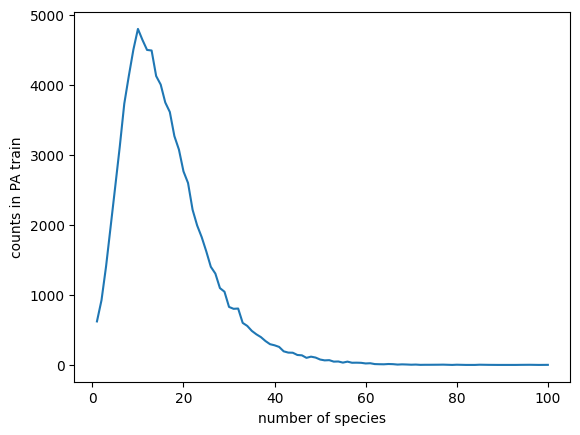

In [313]:
fig = plt.figure()
ax = plt.gca()
plt.plot(tmp.spLen.value_counts(sort=False))
ax.set_xlabel("number of species")
ax.set_ylabel("counts in PA train")
plt.show()

In [41]:
train_landcover = pd.read_csv(os.path.join(path_data, "EnvironmentalValues", "LandCover", "GLC25-PA-train-landcover.csv"), index_col=0)
train_landcover = train_landcover.iloc[:,[0,2,3,5,8,11,12]]
train_wcdummy = pd.get_dummies(train_worldcover["class"], prefix="wc") + 0.0
covercomb = pd.concat([train_landcover, train_wcdummy], axis=1)

AttributeError: 'DataFrame' object has no attribute 'isnan'

In [45]:
train_landcover.isna().sum(0)

LandCover-1     0
LandCover-3     0
LandCover-4     0
LandCover-6     0
LandCover-9     0
LandCover-12    0
LandCover-13    0
dtype: int64

In [47]:
test_landcover = pd.read_csv(os.path.join(path_data, "EnvironmentalValues", "LandCover", "GLC25-PA-test-landcover.csv"), index_col=0)
test_landcover.isna().sum(0)

LandCover-1     0
LandCover-2     0
LandCover-3     0
LandCover-4     0
LandCover-5     0
LandCover-6     0
LandCover-7     0
LandCover-8     0
LandCover-9     0
LandCover-10    0
LandCover-11    0
LandCover-12    0
LandCover-13    0
dtype: int64

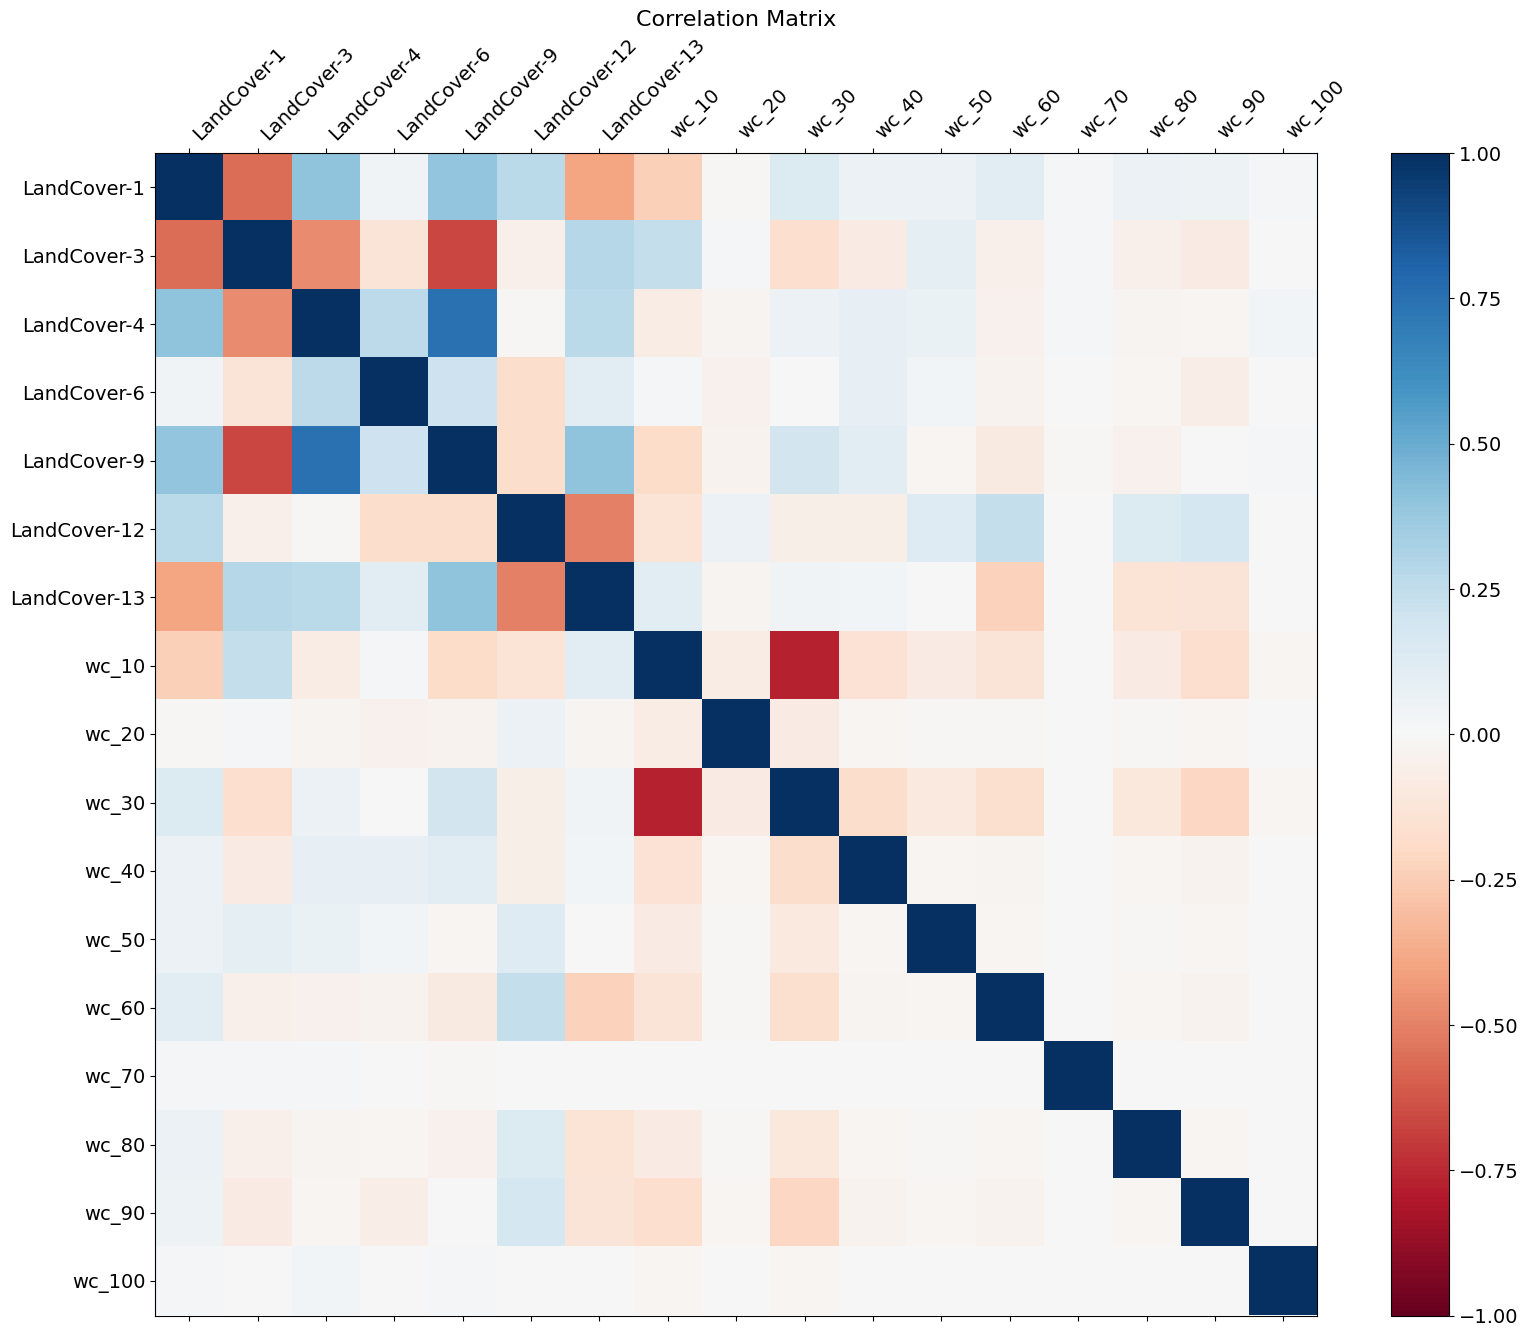

In [40]:
f = plt.figure(figsize=(19, 15))
plt.matshow(covercomb.corr("spearman"), fignum=f.number, vmin=-1, vmax=1, cmap="RdBu")
plt.xticks(range(covercomb.select_dtypes(['number']).shape[1]), covercomb.select_dtypes(['number']).columns, fontsize=14, rotation=45, ha="left")
plt.yticks(range(covercomb.select_dtypes(['number']).shape[1]), covercomb.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
plt.show()


Text(0, 0.5, 'richness')

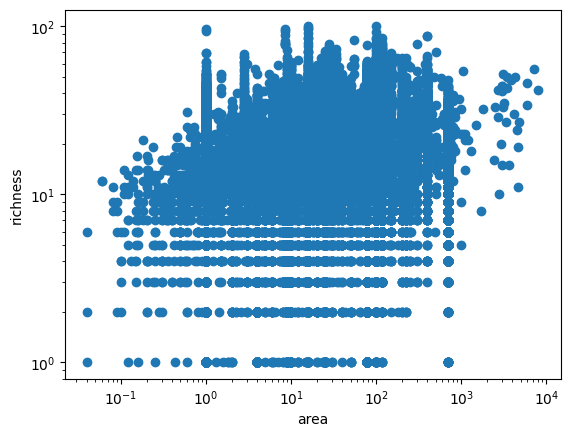

In [342]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(tmp.area, tmp.spLen)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("area")
ax.set_ylabel("richness")

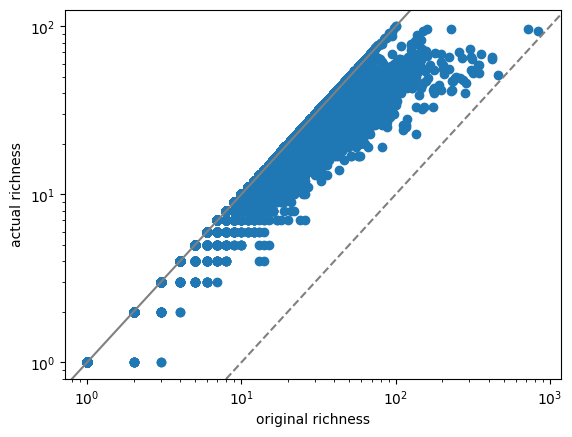

In [189]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(tmp.spLenOrig, tmp.spLen)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("original richness")
ax.set_ylabel("actual richness")
plt.axline([0,0],[1,1], color="gray")
plt.axline([10,1],[100,10], color="gray", linestyle="dashed")

In [17]:
train_worldcover[train_worldcover["class"]==70]

In [244]:
train_worldcover = pd.read_csv(os.path.join(path_data, "worldcover", "s2_pa_train_survey_points_with_worldcover.csv"))
display(train_worldcover.value_counts("class"))
train_wcdummy = pd.get_dummies(train_worldcover["class"], prefix="wc").set_index(train_worldcover.surveyId)
#pd.get_dummies(train_worldcover, columns=["class"])
train_wcdummy

class
30     42974
10     34374
90      3934
40      2737
60      2367
80       996
50       861
20       695
100       44
70         5
Name: count, dtype: int64

,wc_10,wc_20,wc_30,wc_40,wc_50,wc_60,wc_70,wc_80,wc_90,wc_100
surveyId,,,,,,,,,,
212,True,False,False,False,False,False,False,False,False,False
222,False,False,True,False,False,False,False,False,False,False
243,False,False,True,False,False,False,False,False,False,False
324,True,False,False,False,False,False,False,False,False,False
333,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
3919553,True,False,False,False,False,False,False,False,False,False
3919592,True,False,False,False,False,False,False,False,False,False
3919620,False,False,True,False,False,False,False,False,False,False


In [132]:
test_worldcover.value_counts("class")

class
30     6027
10     5110
40     1435
90      634
50      626
60      609
80      182
20      146
100      15
Name: count, dtype: int64

In [109]:
test_worldcover = pd.read_csv(os.path.join(path_data, "worldcover", "pa_test_survey_points_with_worldcover.csv"))
tmp = pd.get_dummies(test_worldcover["class"], prefix="wc").set_index(test_worldcover.surveyId)
tmp.insert(6, "wc_70", False)
tmp

,wc_10,wc_20,wc_30,wc_40,wc_50,wc_60,wc_70,wc_80,wc_90,wc_100
surveyId,,,,,,,,,,
642,True,False,False,False,False,False,False,False,False,False
1792,True,False,False,False,False,False,False,False,False,False
3256,False,False,True,False,False,False,False,False,False,False
3855,False,False,True,False,False,False,False,False,False,False
4889,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
5010108,False,False,False,True,False,False,False,False,False,False
5010109,False,False,True,False,False,False,False,False,False,False
5010110,False,False,False,False,False,False,False,False,True,False


In [113]:
test_worldcover

,surveyId,lon,lat,class
0,642,10.033550,57.120810,10
1,1792,7.333000,46.229970,10
2,3256,1.843658,42.580060,30
3,3855,11.720090,46.261490,30
4,4889,9.361870,55.902450,10
...,...,...,...,...
14779,5010108,34.958290,49.713370,40
14780,5010109,34.959519,45.784336,30
14781,5010110,34.960478,45.782300,90
14782,5010111,34.961731,45.781761,60


In [78]:
path_data = "/home/gt/DATA/geolifeclef-2025"
train_metadata = pd.read_csv(os.path.join(path_data, "GLC25_PA_metadata_train.csv"))
train_metadata = train_metadata.dropna(subset="speciesId").reset_index(drop=True)
train_metadata['speciesId'] = train_metadata['speciesId'].astype(int)
train_metadata["speciesIdOrig"] = train_metadata['speciesId']
tmp = train_metadata["speciesId"].value_counts() >= pa_presence_threshold
train_metadata.loc[~train_metadata["speciesId"].isin(tmp[tmp].index), "speciesId"] = -1
sp_categorical = train_metadata["speciesId"].astype("category").values
num_classes = len(sp_categorical.categories)
train_metadata['speciesId'] = sp_categorical.codes
train_label_series = train_metadata.groupby('surveyId')['speciesId'].apply(list)
train_label_series

surveyId
212        [1805, 117, 2923, 2306, 1196, 2759, 2479, 242,...
222                               [2569, 133, 1187, 105, 59]
243        [1411, 844, 1580, 59, 1836, 370, 1219, 1410, 1...
324                         [2364, 620, 178, 2460, 35, 1787]
333        [643, 241, 1040, 2141, 2684, 1362, 495, 1323, ...
                                 ...                        
3919553    [1645, 2361, 764, 169, 592, 2544, 2691, 59, 25...
3919592                              [237, 1835, 1843, 2786]
3919620    [2569, 1073, 809, 2916, 133, 786, 1187, 516, 1...
3919640    [71, 866, 1925, 415, 2673, 1394, 1183, 844, 18...
3919655    [195, 1219, 2708, 1843, 1580, 1362, 210, 516, ...
Name: speciesId, Length: 88987, dtype: object

In [54]:
train_path_sentinel = os.path.join(path_data, "SatelitePatches/PA-train")
train_path_landsat = os.path.join(path_data, "SateliteTimeSeries-Landsat/cubes/PA-train")
train_path_bioclim = os.path.join(path_data, "BioclimTimeSeries/cubes/PA-train")
train_metadata = pd.read_csv(os.path.join(path_data, "GLC25_PA_metadata_train.csv"))
train_metadata = train_metadata.dropna(subset="speciesId").reset_index(drop=True)
train_metadata['speciesId'] = train_metadata['speciesId'].astype(int)

In [55]:
train_label_series = train_metadata.groupby('speciesId')['surveyId'].apply(list)
species_label = pd.DataFrame(train_label_series)
#train_label_series = train_metadata.groupby('surveyId')['speciesId'].apply(list)
#train_label_series.apply(len)

,surveyId
speciesId,
2,"[249956, 876055, 890998, 958730, 1162857, 1176..."
3,[1974081]
4,"[62976, 124250, 172626, 298514, 334469, 685264..."
7,"[65365, 207414, 262936, 421888, 443273, 456884..."
9,"[2163, 10447, 24928, 35174, 50488, 90385, 1178..."
...,...
11245,"[60996, 3362732, 3659134]"
11246,[684812]
11248,"[418947, 792561, 792561, 1673706, 1673706, 177..."


In [32]:
pa_presence_threshold = 10
tmp = train_metadata["speciesId"].value_counts() >= pa_presence_threshold
train_metadata = train_metadata.loc[train_metadata["speciesId"].isin(tmp[tmp].index)]
train_metadata

,lon,lat,year,geoUncertaintyInM,areaInM2,region,country,speciesId,surveyId,speciesIdNew
0,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,6874,212,6874
1,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,476,212,476
2,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,11157,212,11157
3,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,8784,212,8784
4,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,4530,212,4530
...,...,...,...,...,...,...,...,...,...,...
1483632,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,53,3919655,53
1483633,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,5071,3919655,5071
1483634,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,1889,3919655,1889
1483635,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,10600,3919655,10600


In [56]:
sp_categorical = train_metadata["speciesId"].astype("category").values
sp_categorical.categories

Index([    2,     3,     4,     7,     9,    10,    12,    14,    15,    16,
       ...
       11239, 11240, 11241, 11242, 11243, 11245, 11246, 11248, 11253, 11254],
      dtype='int64', length=5016)

In [38]:
train_metadata["speciesIdNew"] = sp_categorical.categories[sp_categorical.codes]

In [58]:
int(1e6)

1000000

In [40]:
train_metadata

,lon,lat,year,geoUncertaintyInM,areaInM2,region,country,speciesId,surveyId,speciesIdNew
0,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,6874,212,6874
1,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,476,212,476
2,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,11157,212,11157
3,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,8784,212,8784
4,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,4530,212,4530
...,...,...,...,...,...,...,...,...,...,...
1483632,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,53,3919655,53
1483633,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,5071,3919655,5071
1483634,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,1889,3919655,1889
1483635,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,10600,3919655,10600


In [295]:
train_elevation = pd.read_csv(os.path.join(path_data, "EnvironmentalValues", "Elevation", "GLC25-PA-train-elevation.csv"))
train_elevation['Elevation'].fillna((train_elevation['Elevation'].mean()), inplace=True)
print(train_elevation.shape, train_elevation.isin([-np.inf]).sum(0).values, train_elevation.isin([-np.inf]).sum(0).values, train_elevation.isna().sum(0).values)

(88987, 2) [0 0] [0 0] [ 0 35]


In [296]:
test_elevation = pd.read_csv(os.path.join(path_data, "EnvironmentalValues", "Elevation", "GLC25-PA-test-elevation.csv"))
test_elevation['Elevation'].fillna((test_elevation['Elevation'].mean()), inplace=True)
print(test_elevation.shape, test_elevation.isin([-np.inf]).sum(0).values, test_elevation.isin([-np.inf]).sum(0).values, test_elevation.isna().sum(0).values)

(14829, 2) [0 0] [0 0] [0 0]


In [294]:
train_soil = pd.read_csv(os.path.join(path_data, "EnvironmentalValues", "SoilGrids", "GLC25-PA-train-soilgrids.csv"))
for column in train_soil.columns: train_soil[column].fillna((train_soil[column].mean()), inplace=True)
print(train_soil.shape, train_soil.isin([-np.inf]).sum(0).values, train_soil.isin([-np.inf]).sum(0).values, train_soil.isna().sum(0).values, sep='\n')

(88987, 10)
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[   0 8573 7512 7512 7512 7512 7512 7512 7512 8573]


In [298]:
test_soil = pd.read_csv(os.path.join(path_data, "EnvironmentalValues", "SoilGrids", "GLC25-PA-test-soilgrids.csv"))
for column in test_soil.columns: test_soil[column].fillna((test_soil[column].mean()), inplace=True)
print(test_soil.shape, test_soil.isin([-np.inf]).sum(0).values, test_soil.isin([-np.inf]).sum(0).values, test_soil.isna().sum(0).values, sep='\n')

(14829, 10)
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]


In [19]:
combined = pd.concat([train_metadata, train_elevation.Elevation, train_soil.drop("surveyId", axis=1)], axis=1)
print(combined.isna().sum(0))
combined

lon                    0
lat                    0
year                   0
geoUncertaintyInM    521
areaInM2               0
region                 0
country                0
surveyId               0
Elevation              0
Soilgrid-bdod          0
Soilgrid-cec           0
Soilgrid-cfvo          0
Soilgrid-clay          0
Soilgrid-nitrogen      0
Soilgrid-phh2o         0
Soilgrid-sand          0
Soilgrid-silt          0
Soilgrid-soc           0
dtype: int64


,lon,lat,year,geoUncertaintyInM,areaInM2,region,country,surveyId,Elevation,Soilgrid-bdod,Soilgrid-cec,Soilgrid-cfvo,Soilgrid-clay,Soilgrid-nitrogen,Soilgrid-phh2o,Soilgrid-sand,Soilgrid-silt,Soilgrid-soc
0,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,212,47.0,140.0,214.0,151.0,292.0,159.0,73.0,284.0,422.0,176.0
1,9.884560,56.912140,2017,10.0,79.0,CONTINENTAL,Denmark,222,6.0,120.0,225.0,101.0,94.0,379.0,58.0,650.0,255.0,609.0
2,8.256020,55.637050,2019,10.0,79.0,ATLANTIC,Denmark,243,10.0,115.0,261.0,86.0,131.0,373.0,54.0,750.0,117.0,672.0
3,-0.402590,43.505630,2018,1.0,-inf,ATLANTIC,France,324,116.0,118.0,179.0,117.0,225.0,230.0,57.0,238.0,535.0,302.0
4,-0.517360,45.806430,2017,1.0,-inf,ATLANTIC,France,333,84.0,138.0,233.0,176.0,328.0,250.0,71.0,231.0,439.0,257.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88982,10.327990,57.305850,2018,10.0,79.0,CONTINENTAL,Denmark,3919553,23.0,116.0,199.0,65.0,116.0,311.0,59.0,622.0,260.0,485.0
88983,15.003900,55.090170,2017,10.0,707.0,CONTINENTAL,Denmark,3919592,138.0,118.0,245.0,113.0,156.0,405.0,54.0,555.0,288.0,868.0
88984,8.935060,55.461500,2018,10.0,79.0,ATLANTIC,Denmark,3919620,37.0,113.0,233.0,70.0,71.0,253.0,56.0,798.0,129.0,414.0
88985,17.252948,53.901434,2021,5.0,25.0,CONTINENTAL,Poland,3919640,131.0,130.0,162.0,99.0,55.0,234.0,50.0,803.0,141.0,502.0


In [61]:
meta_columns = ["areaInM2", "Elevation"] + list(train_soil.columns[1:])
meta_columns

['areaInM2',
 'Elevation',
 'Soilgrid-bdod',
 'Soilgrid-cec',
 'Soilgrid-cfvo',
 'Soilgrid-clay',
 'Soilgrid-nitrogen',
 'Soilgrid-phh2o',
 'Soilgrid-sand',
 'Soilgrid-silt',
 'Soilgrid-soc']

In [13]:
train_metadata.value_counts(["areaInM2", "country"])

areaInM2  country    
 79.0     Denmark        42647
-inf      France         10258
 707.0    Denmark         6697
 4.0      Netherlands     4422
 9.0      Netherlands     2195
                         ...  
 90.0     Spain              1
 10.0     Norway             1
 90.0     Italy              1
          Germany            1
 8000.0   Netherlands        1
Name: count, Length: 866, dtype: int64

In [25]:
train_metadata = pd.read_csv(os.path.join(path_data, "GLC25_PA_metadata_train.csv"))
train_metadata.groupby('surveyId')['speciesId'].apply(list)[212]

[6874.0,
 476.0,
 11157.0,
 8784.0,
 4530.0,
 10520.0,
 9458.0,
 982.0,
 51.0,
 3935.0,
 11193.0,
 2421.0,
 2159.0,
 9030.0,
 2932.0,
 1304.0]

In [ ]:
print(train_dataset[0][1].shape)
#val = np.zeros([len(train_dataset)])
#for i, d in enumerate(tqdm.tqdm(train_dataset)):
#    val[i] = torch.sum(torch.sum(torch.reshape(torch.permute(d[1], [0,2,1]), [6, -1]), -2) == 0).numpy()

In [ ]:
train_metadata.speciesId.drop_duplicates().sort_values()
prev_min = 10
train_metadata.value_counts("speciesId").sort_index().pipe(lambda x: x[x>=prev_min])

In [ ]:
plt.plot(np.log10(train_metadata.value_counts("speciesId").values))

In [60]:
test_metadata = pd.read_csv(os.path.join(path_data, "GLC25_PA_metadata_test.csv"))
test_metadata

,lon,lat,year,geoUncertaintyInM,areaInM2,region,country,surveyId
0,10.033550,57.120810,2019,10.0,707.0,CONTINENTAL,Denmark,642
1,7.333000,46.229970,2019,NaN,10.0,ALPINE,Switzerland,1792
2,1.843658,42.580060,2018,0.0,-inf,ALPINE,France,3256
3,11.720090,46.261490,2021,10.0,35.0,ALPINE,Italy,3855
4,9.361870,55.902450,2017,10.0,79.0,CONTINENTAL,Denmark,4889
...,...,...,...,...,...,...,...,...
14779,4.148978,43.989024,2021,4.0,150.0,MEDITERRANEAN,France,5000929
14780,3.523861,43.700529,2021,5.0,250.0,MEDITERRANEAN,France,5000922
14781,3.562852,43.864276,2021,5.0,250.0,MEDITERRANEAN,France,5000927
14782,3.557167,43.864581,2021,7.0,250.0,MEDITERRANEAN,France,5000925


In [ ]:
(train_metadata.country.value_counts().cumsum() / test_metadata.shape[0]).index[:10].values

In [ ]:

test_metadata.country.isin(most_train_countries).sum()

In [49]:
train_metadata

,lon,lat,year,geoUncertaintyInM,areaInM2,region,country,speciesId,surveyId
0,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,6874.0,212
1,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,476.0,212
2,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,11157.0,212
3,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,8784.0,212
4,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,4530.0,212
...,...,...,...,...,...,...,...,...,...
1483632,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,53.0,3919655
1483633,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,5071.0,3919655
1483634,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,1889.0,3919655
1483635,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,10600.0,3919655


In [56]:
train_metadata_surv = train_metadata.drop_duplicates("surveyId")
train_summary = pd.DataFrame(train_metadata_surv.value_counts("country"))
train_summary["prop"] = train_summary.loc[:,"count"] / train_summary.loc[:,"count"].sum()
train_summary

,count,prop
country,,
Denmark,49344,0.554508
Netherlands,15024,0.168834
France,13501,0.151719
Italy,2602,0.029240
Belgium,1849,0.020778
Austria,1261,0.014171
Germany,1120,0.012586
Czech Republic,1051,0.011811
Montenegro,904,0.010159


In [57]:
test_summary = pd.DataFrame(test_metadata.value_counts("country"))
test_summary["prop"] = test_summary.loc[:,"count"] / test_summary.loc[:,"count"].sum()
test_summary["cumprop"] = test_summary.loc[:,"prop"].cumsum()
test_summary

,count,prop,cumprop
country,,,
Bulgaria,3273,0.221388,0.221388
Ukraine,2911,0.196902,0.418290
Switzerland,1982,0.134064,0.552354
France,1468,0.099297,0.651650
Denmark,1453,0.098282,0.749932
Netherlands,846,0.057224,0.807156
United Kingdom,843,0.057021,0.864177
Italy,558,0.037744,0.901921
Belarus,268,0.018128,0.920049


In [58]:
test_summary.join(train_summary, lsuffix="_test", rsuffix="_train")

,count_test,prop_test,cumprop,count_train,prop_train
country,,,,,
Bulgaria,3273,0.221388,0.221388,81.0,0.000910
Ukraine,2911,0.196902,0.418290,NaN,NaN
Switzerland,1982,0.134064,0.552354,155.0,0.001742
France,1468,0.099297,0.651650,13501.0,0.151719
Denmark,1453,0.098282,0.749932,49344.0,0.554508
Netherlands,846,0.057224,0.807156,15024.0,0.168834
United Kingdom,843,0.057021,0.864177,NaN,NaN
Italy,558,0.037744,0.901921,2602.0,0.029240
Belarus,268,0.018128,0.920049,NaN,NaN


In [80]:
def set_seed(seed):
    torch.manual_seed(seed) # Set seed for Python's built-in random number generator
    np.random.seed(seed) # Set seed for numpy
    if torch.cuda.is_available(): # Set seed for CUDA if available
        torch.cuda.manual_seed_all(seed)
        # Set cuDNN's random number generator seed for deterministic behavior
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)
path_data = "/home/gt/DATA/geolifeclef-2025"
train_path_sentinel = os.path.join(path_data, "SatelitePatches/PA-train")
train_path_landsat = os.path.join(path_data, "SateliteTimeSeries-Landsat/cubes/PA-train")
train_path_bioclim = os.path.join(path_data, "BioclimTimeSeries/cubes/PA-train")
train_metadata = pd.read_csv(os.path.join(path_data, "GLC25_PA_metadata_train.csv"))
train_metadata = train_metadata.dropna(subset="speciesId").reset_index(drop=True)
train_metadata['speciesId'] = train_metadata['speciesId'].astype(int)
train_metadata["speciesIdOrig"] = train_metadata['speciesId']
tmp = train_metadata["speciesId"].value_counts() >= pa_presence_threshold
train_metadata.loc[~train_metadata["speciesId"].isin(tmp[tmp].index), "speciesId"] = -1
sp_categorical = train_metadata["speciesId"].astype("category").values
num_classes = len(sp_categorical.categories)
train_metadata['speciesId'] = sp_categorical.codes

tmp = train_metadata.groupby("surveyId").agg({"surveyId":"first", "lat":"first", "lon":"first", "areaInM2":lambda x: list(x.unique()), "region":"first", "country":"first", "speciesId":list})
train_label_series = tmp.set_index("surveyId").speciesId
train_metadata = tmp.drop(columns=["speciesId"]).set_index("surveyId", drop=False)
train_metadata["area"] = train_metadata["areaInM2"].apply(lambda x: 1.0 if np.isinf(x).all() else np.mean(x, where=~np.isinf(x)))
train_metadata["areaLog"] = np.log10(train_metadata["area"])

train_metadata['area'].fillna(train_metadata['area'].mean(), inplace=True)
train_metadata['areaLog'].fillna(train_metadata['areaLog'].mean(), inplace=True)
train_metadata["conFra"] = train_metadata["country"] == "France"
train_metadata["conDen"] = train_metadata["country"] == "Denmark"
train_metadata["conNet"] = train_metadata["country"] == "Netherlands"
train_metadata["conIta"] = train_metadata["country"] == "Italy"
train_metadata["conAus"] = train_metadata["country"] == "Austria"
train_metadata["conOther"] = ~train_metadata["country"].isin(["France","Denmark","Netherlands","Italy","Austria"])
train_elevation = pd.read_csv(os.path.join(path_data, "EnvironmentalValues", "Elevation", "GLC25-PA-train-elevation.csv"), index_col=0)
train_elevation['Elevation'].fillna((train_elevation['Elevation'].mean()), inplace=True)
train_soil = pd.read_csv(os.path.join(path_data, "EnvironmentalValues", "SoilGrids", "GLC25-PA-train-soilgrids.csv"), index_col=0)
for column in train_soil.columns: train_soil[column].fillna((train_soil[column].mean()), inplace=True)
train_worldcover = pd.read_csv(os.path.join(path_data, "worldcover", "s2_pa_train_survey_points_with_worldcover.csv"), index_col=0)
train_wcdummy = pd.get_dummies(train_worldcover["class"], prefix="wc")
train_wcdummy.drop(columns="wc_70", inplace=True)
train_wcdummy.drop(columns="wc_100", inplace=True)
train_landcover = pd.read_csv(os.path.join(path_data, "EnvironmentalValues", "LandCover", "GLC25-PA-train-landcover.csv"), index_col=0)
landcover_col_ind = [0,2,3,5,8,11,12]
train_landcover = train_landcover.iloc[:, landcover_col_ind]

print("All rows match: ", (train_metadata.index==train_elevation.index).all() and (train_metadata.index==train_soil.index).all() \
     and (train_metadata.index==train_worldcover.index).all() and (train_metadata.index==train_landcover.index).all())
cov_columns = ["areaLog", "Elevation", "conFra", "conDen", "conNet", "conIta", "conAus", "conOther"] + list(train_soil.columns) + list(train_wcdummy.columns) + list(train_landcover.columns)
train_combined = pd.concat([train_metadata, train_elevation.Elevation, train_soil, train_wcdummy, train_landcover], axis=1)
cov_norm_coef = train_combined.loc[:,cov_columns].agg(['mean', 'std'])
dummy_columns = ["conFra","conDen","conNet","conIta","conAus","conOther"] + list(train_wcdummy.columns)
cov_norm_coef.loc["mean",dummy_columns] = 0
cov_norm_coef.loc["std",dummy_columns] = 1
train_combined.loc[:,cov_columns] = (train_combined.loc[:,cov_columns] - cov_norm_coef.loc["mean"]) / cov_norm_coef.loc["std"]

val_ind = np.sort(train_combined.surveyId.sample(frac=validation_prop).values)
train_data, val_data = [x.reset_index(drop=True) for _, x in train_combined.groupby(train_combined.surveyId.isin(val_ind))]
train_label_dict = train_label_series[train_data.surveyId].to_dict()
val_label_dict = train_label_series[val_data.surveyId].to_dict()
train_dataset = TrainDataset(train_path_sentinel, train_path_landsat, train_path_bioclim, train_data, cov_columns, train_label_dict, 
                             subset="train", num_classes=num_classes, transform_sentinel=transform_sentinel, transform_landsat=transform_landsat)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataset = TrainDataset(train_path_sentinel, train_path_landsat, train_path_bioclim, val_data, cov_columns, val_label_dict,
                           subset="train", num_classes=num_classes, transform_sentinel=transform_sentinel_test, transform_landsat=transform_landsat_test)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
print(train_dataset[0][0].shape, val_dataset[0][2].shape)

NameError: name 'torch' is not defined

In [65]:
pred = pd.read_csv("prithvi/0424_225841/0425_012850_e075_vloss0.008629_vf0.3079.csv", index_col=0)
test_metadata = pd.read_csv(os.path.join(path_data, "GLC25_PA_metadata_test.csv"), index_col=-1)
pred = pd.concat([test_metadata, pred], axis=1)
pred_na = pred.loc[pred.predictions.isna()]

In [73]:
pred_na

,lon,lat,year,geoUncertaintyInM,areaInM2,region,country,predictions
surveyId,,,,,,,,
5003289,19.974680,41.669770,2017,NaN,NaN,MEDITERRANEAN,Albania,NaN
5003310,20.224890,42.251560,2017,NaN,NaN,ALPINE,Albania,NaN
5003277,19.910560,41.367600,2017,NaN,100.0,MEDITERRANEAN,Albania,NaN
5003278,19.910980,41.367260,2017,NaN,150.0,MEDITERRANEAN,Albania,NaN
5003279,19.911430,41.367360,2017,NaN,50.0,MEDITERRANEAN,Albania,NaN
...,...,...,...,...,...,...,...,...
5000917,3.346753,43.355024,2021,5.0,200.0,MEDITERRANEAN,France,NaN
5000913,3.232405,43.395339,2021,4.0,16.0,MEDITERRANEAN,France,NaN
5000928,4.140144,43.973277,2021,4.0,250.0,MEDITERRANEAN,France,NaN


In [78]:
pd.concat([test_metadata.value_counts("country"), pred_na.value_counts("country")], axis=1).fillna(0).astype(int)

,count,count
country,,
Bulgaria,3273,2698
Ukraine,2911,2795
Switzerland,1982,1581
France,1468,78
Denmark,1453,0
Netherlands,846,0
United Kingdom,843,841
Italy,558,106
Belarus,268,76


country
Bulgaria                  3273
Ukraine                   2911
Switzerland               1982
France                    1468
Denmark                   1453
Netherlands                846
United Kingdom             843
Italy                      558
Belarus                    268
Austria                    238
Turkey                     143
Albania                    140
Poland                     110
Spain                       79
Belgium                     71
Russian Federation          65
Croatia                     59
Sweden                      52
Finland                     51
Montenegro                  48
Slovenia                    39
Latvia                      34
Norway                      11
Czech Republic              10
Bosnia and Herzegovina       7
Greece                       5
Malta                        5
Slovakia                     4
Bosnia-Herzegovina           3
Germany                      2
Kosovo                       2
Serbia                       2
